1. На основе учебного ноутбука проведите финальную подготовку данных. Иизмените количество сегментирующих классов с `16` на `5`.

2. Проведите суммарно не менее `10` экспериментов и визуализируйте их результаты (включая точность обучения сетей на одинаковом количестве эпох, например, на `7`):

  - изменив `filters` в сверточных слоях
  - изменив `kernel_size` в сверточных слоях
  - изменив активационную функцию в скрытых слоях с `relu` на `linear` или/и `selu`, `elu`.


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

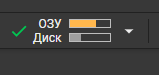



Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка

### Импорт библиотек

In [1]:
# Стандартные библиотеки
import os  # Для работы с файловой системой
import zipfile  # Для распаковки архивов
import time  # Для измерения времени выполнения
import random  # Для генерации случайных чисел
import gc  # Для управления памятью

# Научные вычисления
import numpy as np  # Для работы с массивами

# Визуализация
import matplotlib.pyplot as plt  # Для построения графиков
from PIL import Image  # Для работы с изображениями

# Глубокое обучение
import tensorflow as tf
from tensorflow.keras.models import Model  # Базовый класс модели
from tensorflow.keras.layers import (  # Слои нейросети
    Input, Conv2D, Conv2DTranspose,
    BatchNormalization, MaxPooling2D,
    concatenate, Activation
)
from tensorflow.keras.optimizers import Adam  # Оптимизатор
from tensorflow.keras.preprocessing import image  # Для загрузки изображений

# Загрузка данных
import gdown  # Для скачивания файлов

### Загрузка датасета

Функция для загрузки и распаковки датасета

In [2]:
def download_and_extract(url, output_dir):
    """Скачивает и распаковывает архив с датасетом"""
    # Создаем папку для данных, если ее нет
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Путь для сохранения архива
    zip_path = os.path.join(output_dir, 'dataset.zip')

    # Скачиваем архив
    print("Скачивание архива...")
    gdown.download(url, zip_path, quiet=False)

    # Распаковываем архив
    print("Распаковка архива...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

    # Удаляем архив
    os.remove(zip_path)
    print("Датасет готов к использованию")

Распаковка датасета

In [3]:
# Глобальные параметры
DATASET_URL = 'https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip'
IMG_WIDTH = 256               # Ширина картинки
IMG_HEIGHT = 192              # Высота картинки
NUM_CLASSES = 16              # Задаем количество классов на изображении
DATA_DIR = 'construction_data'
TRAIN_DIRECTORY = os.path.join(DATA_DIR, 'train')    # Название папки с файлами обучающей выборки
VAL_DIRECTORY = os.path.join(DATA_DIR, 'val')         # Название папки с файлами проверочной выборки
# Скачиваем и распаковываем датасет
download_and_extract(DATASET_URL, DATA_DIR)

Скачивание архива...


Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip
To: /content/construction_data/dataset.zip
100%|██████████| 214M/214M [00:02<00:00, 72.0MB/s]


Распаковка архива...
Датасет готов к использованию


Загрузим оригинальные изображения (код из лекции):

In [4]:
train_images = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_images.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/original',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающей выборке
print ('Количество изображений: ', len(train_images))

cur_time = time.time() # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_images.append(image.load_img(os.path.join(VAL_DIRECTORY+'/original',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочной выборке
print ('Количество изображений: ', len(val_images))

Обучающая выборка загружена. Время загрузки: 0.7c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.03c
Количество изображений:  100


Загрузим сегментированные изображения (код из лекции):

In [5]:
train_segments = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_segments.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/segment',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающем наборе сегментированных изображений
print ('Количество изображений: ', len(train_segments))

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(VAL_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_segments.append(image.load_img(os.path.join(VAL_DIRECTORY+'/segment',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочном наборе сегментированных изображений
print ('Количество изображений: ', len(val_segments))

Обучающая выборка загружена. Время загрузки: 0.65c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.03c
Количество изображений:  100


## Решение


Обработка сегментов и преобразование изображений и меток в numpy массивы

In [6]:
# Функция для обработки сегментов
def process_segment(segments):
    processed = []
    for seg in segments:
        seg_array = np.array(seg)
        if seg_array.ndim == 3:
            seg_array = seg_array[:, :, 0]  # Берем первый канал если изображение RGB
        seg_array = seg_array % NUM_CLASSES  # Преобразуем метки в диапазон 0-4
        processed.append(seg_array)
    return processed

# Обработка сегментов
train_segments = process_segment(train_segments)
val_segments = process_segment(val_segments)

# Преобразование изображений и меток в numpy массивы
X_train = np.array([image.img_to_array(img)/255.0 for img in train_images])
y_train = np.array([seg for seg in train_segments], dtype=np.uint8)
X_val = np.array([image.img_to_array(img)/255.0 for img in val_images])
y_val = np.array([seg for seg in val_segments], dtype=np.uint8)

Создание модели на основе U-Net

In [7]:
# Модифицированная модель U-Net
def masked_unet(class_count, input_shape, filters_list, kernel_size=(3,3), activation='relu'):
    img_input = Input(input_shape)
    # (Чтобы опять всё не легло!) Добавлена проверка kernel_size
    if isinstance(kernel_size, list):
        assert len(kernel_size) == 5, "kernel_size list must have 5 elements"
    else:
        kernel_size = [kernel_size]*5
    # Block 1
    x = Conv2D(filters_list[0], kernel_size[0], padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[0], kernel_size[0], padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation(activation)(x)
    block_1_out_mask = Conv2D(filters_list[0], (1,1), padding='same')(block_1_out)
    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(filters_list[1], kernel_size[1], padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[1], kernel_size[1], padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation(activation)(x)
    block_2_out_mask = Conv2D(filters_list[1], (1,1), padding='same')(block_2_out)
    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(filters_list[2], kernel_size[2], padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[2], kernel_size[2], padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation(activation)(x)
    block_3_out_mask = Conv2D(filters_list[2], (1,1), padding='same')(block_3_out)
    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(filters_list[3], kernel_size[3], padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[3], kernel_size[3], padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation(activation)(x)
    block_4_out_mask = Conv2D(filters_list[3], (1,1), padding='same')(block_4_out)
    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(filters_list[4], kernel_size[4], padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[4], kernel_size[4], padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # Декодинг
    # UP 1
    x = Conv2DTranspose(filters_list[3], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_4_out, block_4_out_mask])
    x = Conv2D(filters_list[3], kernel_size[3], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # UP 2
    x = Conv2DTranspose(filters_list[2], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_3_out, block_3_out_mask])
    x = Conv2D(filters_list[2], kernel_size[2], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # UP 3
    x = Conv2DTranspose(filters_list[1], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_2_out, block_2_out_mask])
    x = Conv2D(filters_list[1], kernel_size[1], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # UP 4
    x = Conv2DTranspose(filters_list[0], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_1_out, block_1_out_mask])
    x = Conv2D(filters_list[0], kernel_size[0], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # Последний слой
    x = Conv2D(class_count, (3,3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                 loss='sparse_categorical_crossentropy',
                 metrics=['sparse_categorical_accuracy'])
    return model

Список экспериментов, которые будут проводиться

Базовая модель (Basic)

Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 192s 555ms/step - loss: 0.8883 - sparse_categorical_accuracy: 0.6716 - val_loss: 0.9480 - val_sparse_categorical_accuracy: 0.7105
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 112s 378ms/step - loss: 0.6082 - sparse_categorical_accuracy: 0.7602 - val_loss: 0.7678 - val_sparse_categorical_accuracy: 0.7286
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 90s 378ms/step - loss: 0.5556 - sparse_categorical_accuracy: 0.7838 - val_loss: 0.7364 - val_sparse_categorical_accuracy: 0.7170
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 379ms/step - loss: 0.5228 - sparse_categorical_accuracy: 0.7952 - val_loss: 0.7517 - val_sparse_categorical_accuracy: 0.7152
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 379ms/step - loss: 0.4996 - sparse_categorical_accuracy: 0.8065 - val_loss: 0.6715 - val_sparse_categorical_accuracy: 0.7195
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 379ms/step - loss: 0.4522 - sparse_categorical_accuracy: 0.8271 - val_loss: 0.7042 - val_sparse_categorical_accu

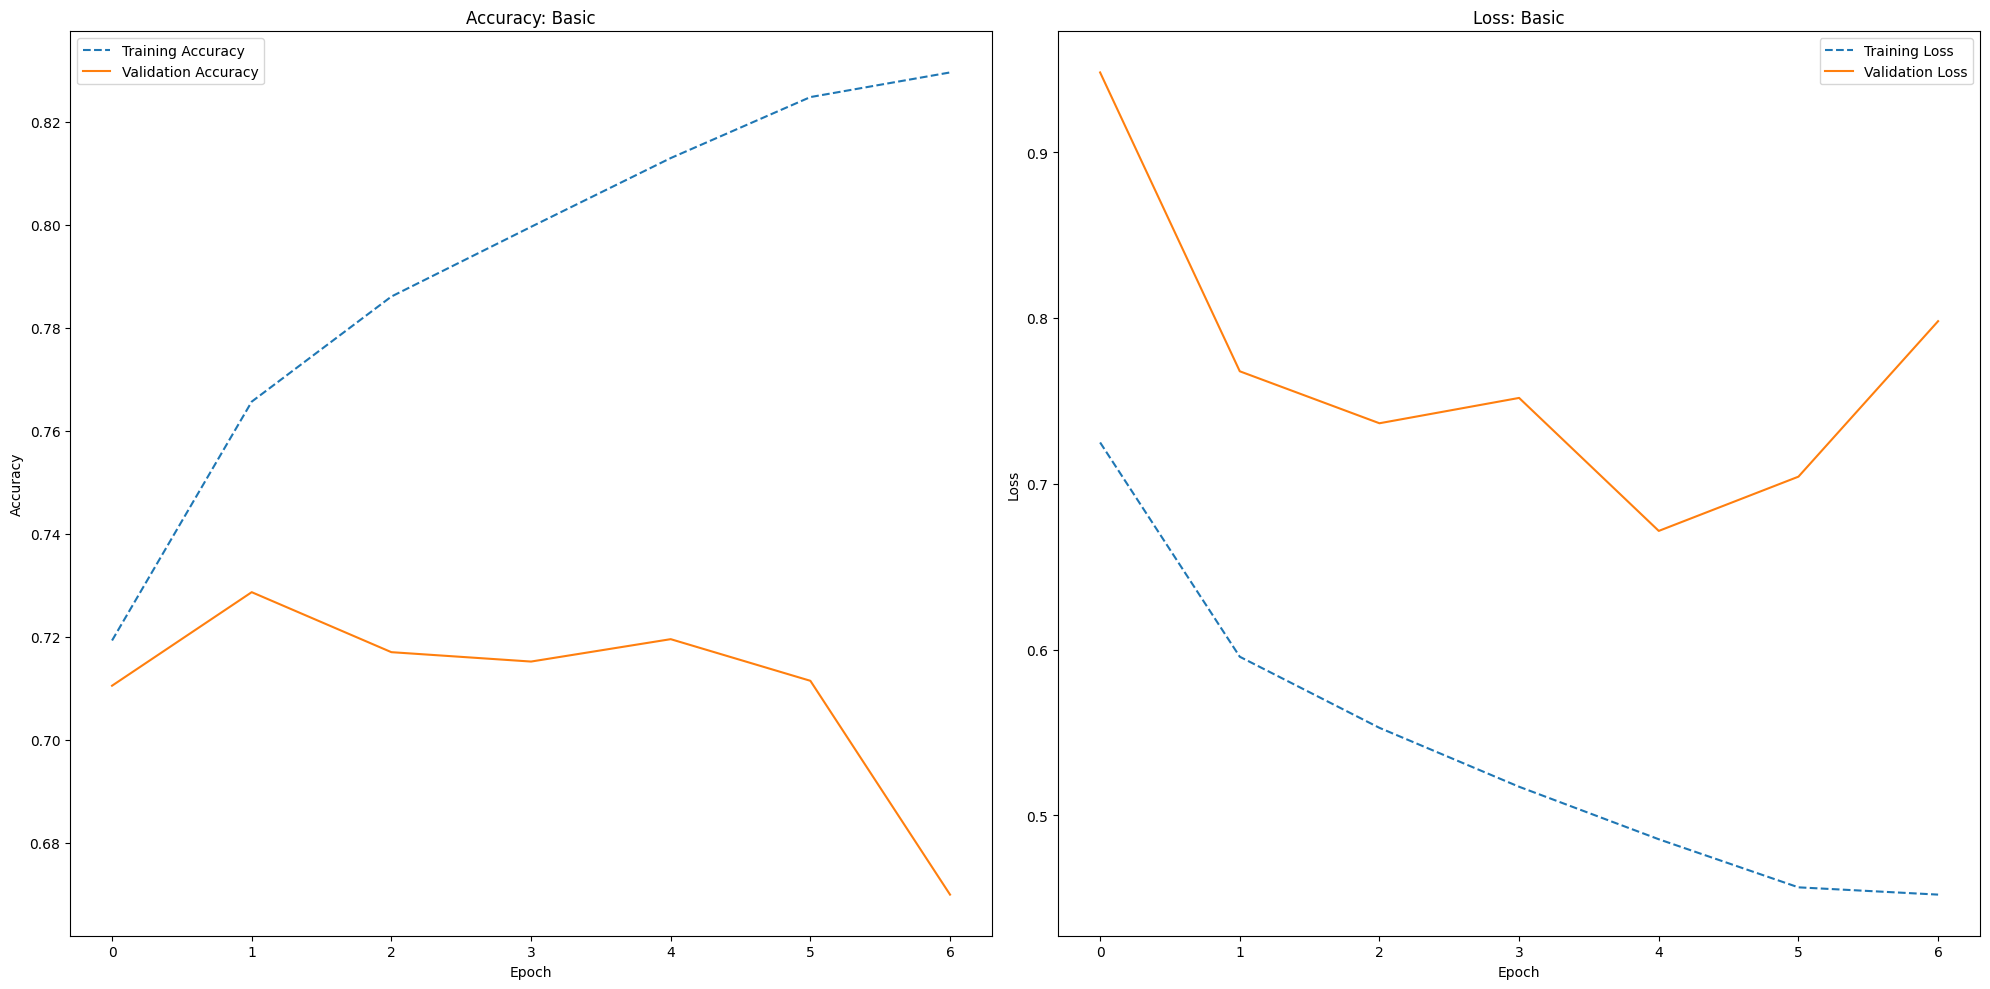

7580

In [8]:
# Параметры модели
params = {
    'name': 'Basic',
    'filters': [64, 128, 256, 512, 512],
    'kernel_size': (3,3),
    'activation': 'relu'
}

# Создание модели
model = masked_unet(
    class_count=NUM_CLASSES,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    filters_list=params['filters'],
    kernel_size=params['kernel_size'],
    activation=params['activation']
)

# Обучение
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=7,
    batch_size=8,
    verbose=1
)

# Визуализация
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
plt.title(f'Accuracy: {params["name"]}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], '--', label='Training Loss')
plt.plot(history.history['val_loss'], '-', label='Validation Loss')
plt.title(f'Loss: {params["name"]}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Очистка
del model
gc.collect()

Модель с уменьшенным ядром (Kernel 1,1)

Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 90s 251ms/step - loss: 0.9699 - sparse_categorical_accuracy: 0.6307 - val_loss: 1.0136 - val_sparse_categorical_accuracy: 0.6417
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 43s 165ms/step - loss: 0.7277 - sparse_categorical_accuracy: 0.6899 - val_loss: 0.8635 - val_sparse_categorical_accuracy: 0.6286
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - loss: 0.6963 - sparse_categorical_accuracy: 0.7057 - val_loss: 0.9304 - val_sparse_categorical_accuracy: 0.5936
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 39s 165ms/step - loss: 0.7034 - sparse_categorical_accuracy: 0.7014 - val_loss: 0.9608 - val_sparse_categorical_accuracy: 0.5631
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 39s 165ms/step - loss: 0.6640 - sparse_categorical_accuracy: 0.7190 - val_loss: 0.9498 - val_sparse_categorical_accuracy: 0.5600
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - loss: 0.6592 - sparse_categorical_accuracy: 0.7177 - val_loss: 0.8568 - val_sparse_categorical_accuracy:

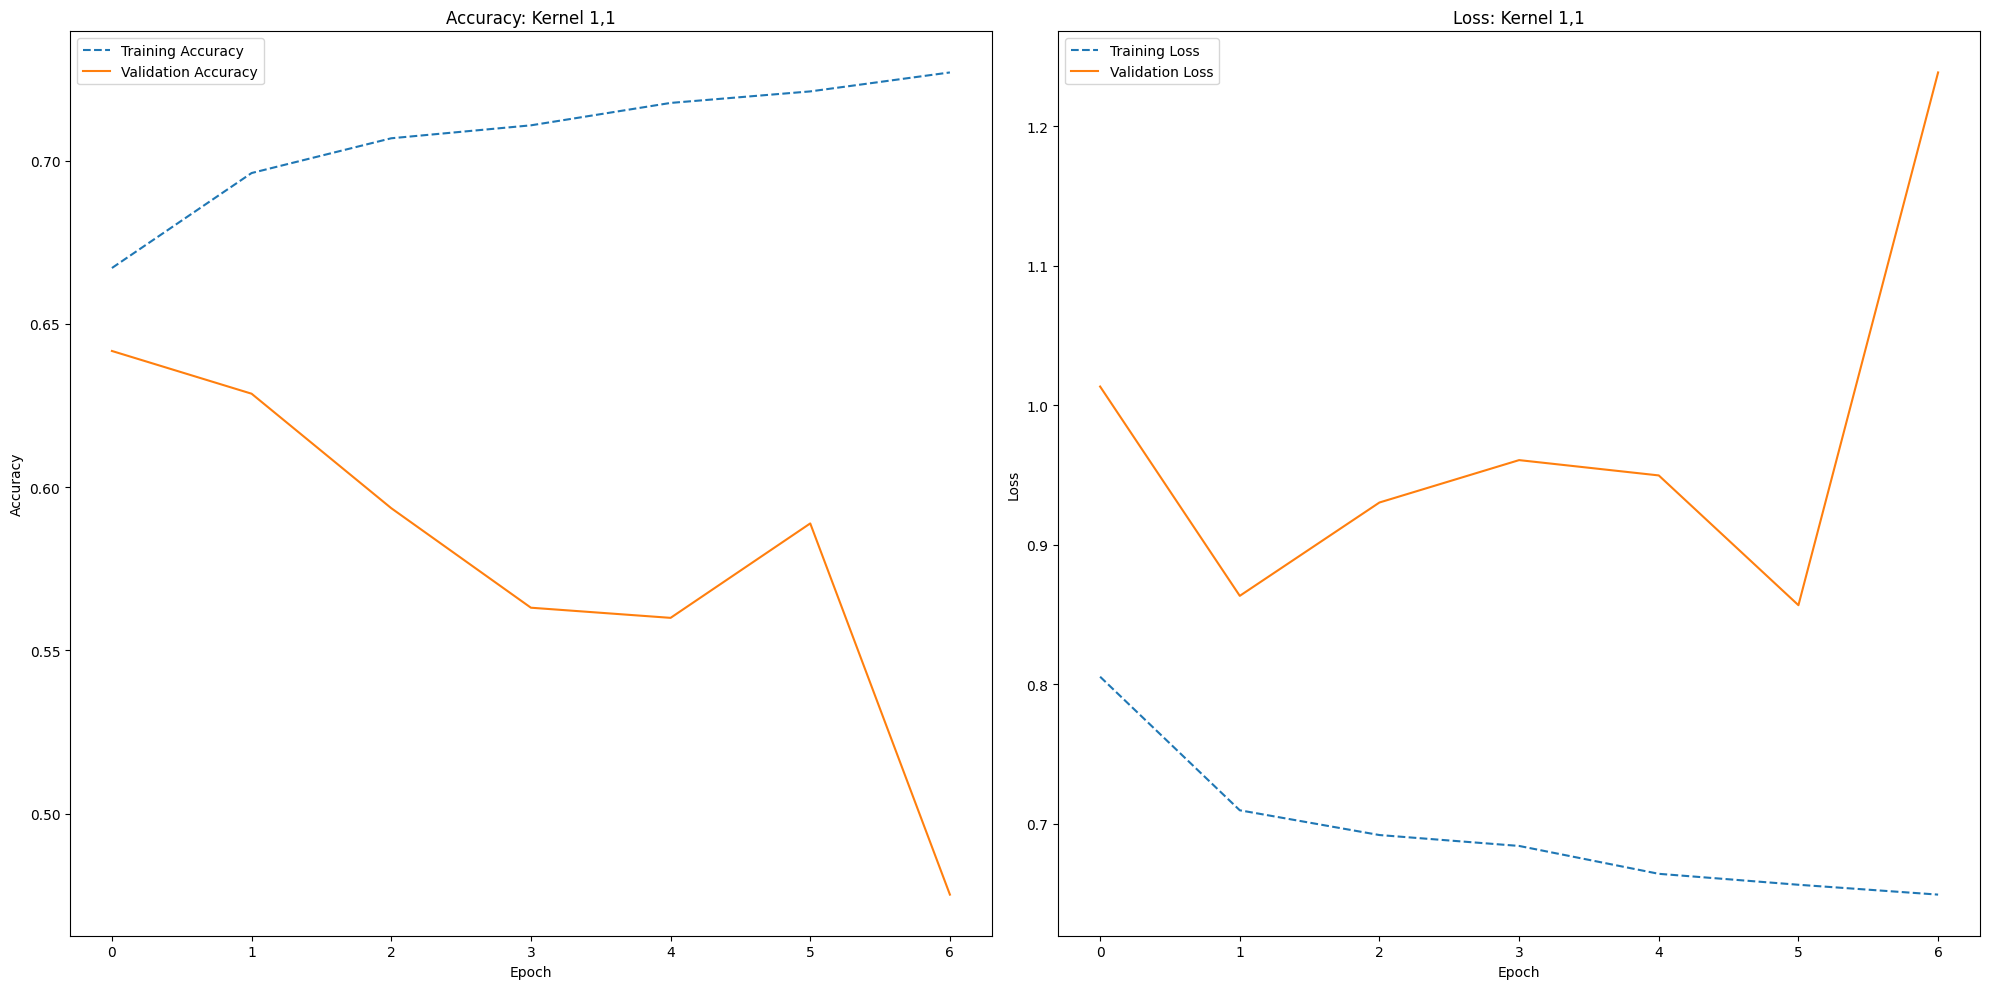

29493

In [9]:
# Параметры модели
params = {
    'name': 'Kernel 1,1',
    'filters': [64, 128, 256, 512, 512],
    'kernel_size': (1,1),
    'activation': 'relu'
}

# Создание модели
model = masked_unet(
    class_count=NUM_CLASSES,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    filters_list=params['filters'],
    kernel_size=params['kernel_size'],
    activation=params['activation']
)

# Обучение и визуализация (аналогично предыдущему)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7, batch_size=8, verbose=1)

# Визуализация
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
plt.title(f'Accuracy: {params["name"]}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], '--', label='Training Loss')
plt.plot(history.history['val_loss'], '-', label='Validation Loss')
plt.title(f'Loss: {params["name"]}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Очистка
del model
gc.collect()

Модель с линейной активацией (Linear)

Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 126s 432ms/step - loss: 1.9582 - sparse_categorical_accuracy: 0.5013 - val_loss: 1.1460 - val_sparse_categorical_accuracy: 0.7066
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 117s 376ms/step - loss: 0.6917 - sparse_categorical_accuracy: 0.7359 - val_loss: 0.8524 - val_sparse_categorical_accuracy: 0.7134
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 143s 380ms/step - loss: 0.6319 - sparse_categorical_accuracy: 0.7554 - val_loss: 1.1246 - val_sparse_categorical_accuracy: 0.6596
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 377ms/step - loss: 0.6452 - sparse_categorical_accuracy: 0.7485 - val_loss: 0.9127 - val_sparse_categorical_accuracy: 0.6673
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 377ms/step - loss: 0.5984 - sparse_categorical_accuracy: 0.7698 - val_loss: 1.0370 - val_sparse_categorical_accuracy: 0.6436
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 377ms/step - loss: 0.5950 - sparse_categorical_accuracy: 0.7707 - val_loss: 0.9013 - val_sparse_categorical_acc

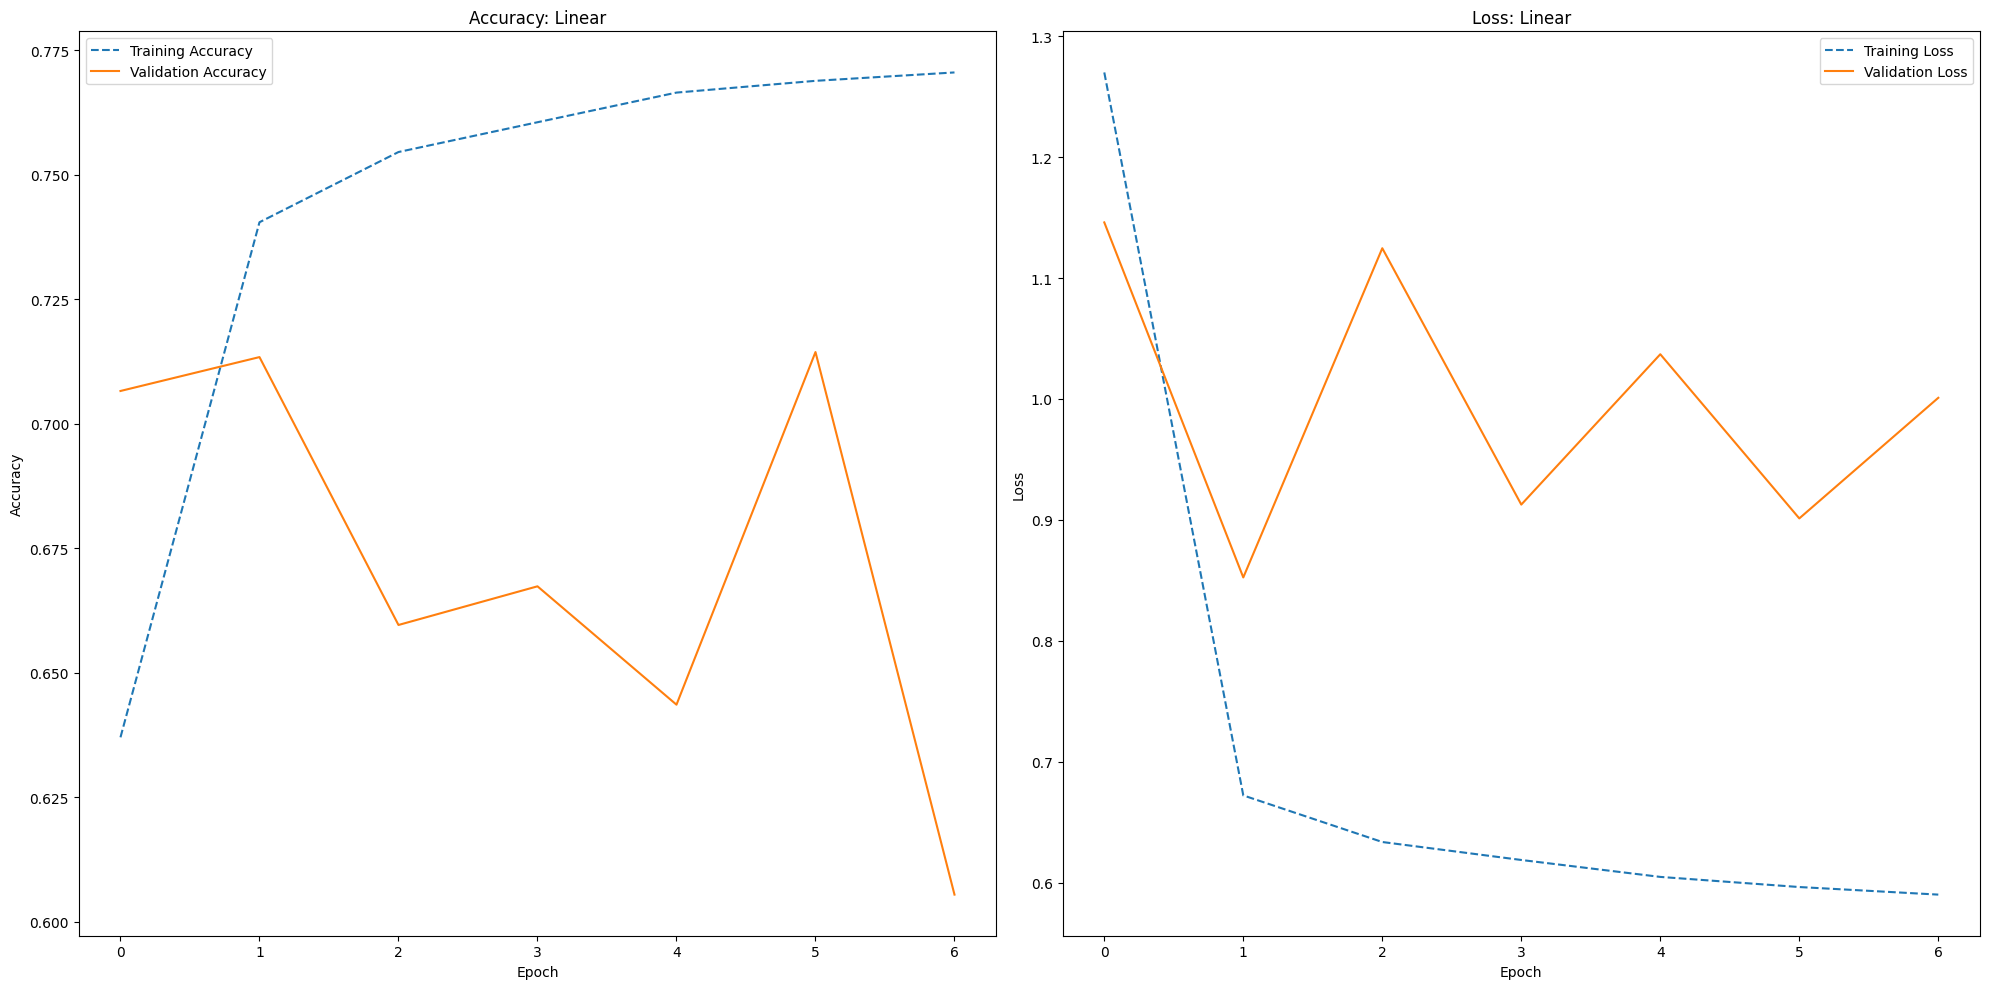

30053

In [10]:
params = {
    'name': 'Linear',
    'filters': [64, 128, 256, 512, 512],
    'kernel_size': (3,3),
    'activation': 'linear'
}

model = masked_unet(
    class_count=NUM_CLASSES,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    filters_list=params['filters'],
    kernel_size=params['kernel_size'],
    activation=params['activation']
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7, batch_size=8, verbose=1)

# Визуализация
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
plt.title(f'Accuracy: {params["name"]}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], '--', label='Training Loss')
plt.plot(history.history['val_loss'], '-', label='Validation Loss')
plt.title(f'Loss: {params["name"]}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Очистка
del model
gc.collect()

Модель с удвоенными фильтрами (Filters*2)

Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 462s 1s/step - loss: 0.8790 - sparse_categorical_accuracy: 0.6726 - val_loss: 1.0652 - val_sparse_categorical_accuracy: 0.7017
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - loss: 0.6284 - sparse_categorical_accuracy: 0.7512 - val_loss: 0.9335 - val_sparse_categorical_accuracy: 0.6684
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.5763 - sparse_categorical_accuracy: 0.7738 - val_loss: 0.7237 - val_sparse_categorical_accuracy: 0.7101
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.5462 - sparse_categorical_accuracy: 0.7870 - val_loss: 1.0571 - val_sparse_categorical_accuracy: 0.5815
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.4916 - sparse_categorical_accuracy: 0.8123 - val_loss: 0.7457 - val_sparse_categorical_accuracy: 0.6868
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.4938 - sparse_categorical_accuracy: 0.8113 - val_loss: 0.6280 - val_sparse_categorical_accuracy: 0.7487
Epoc

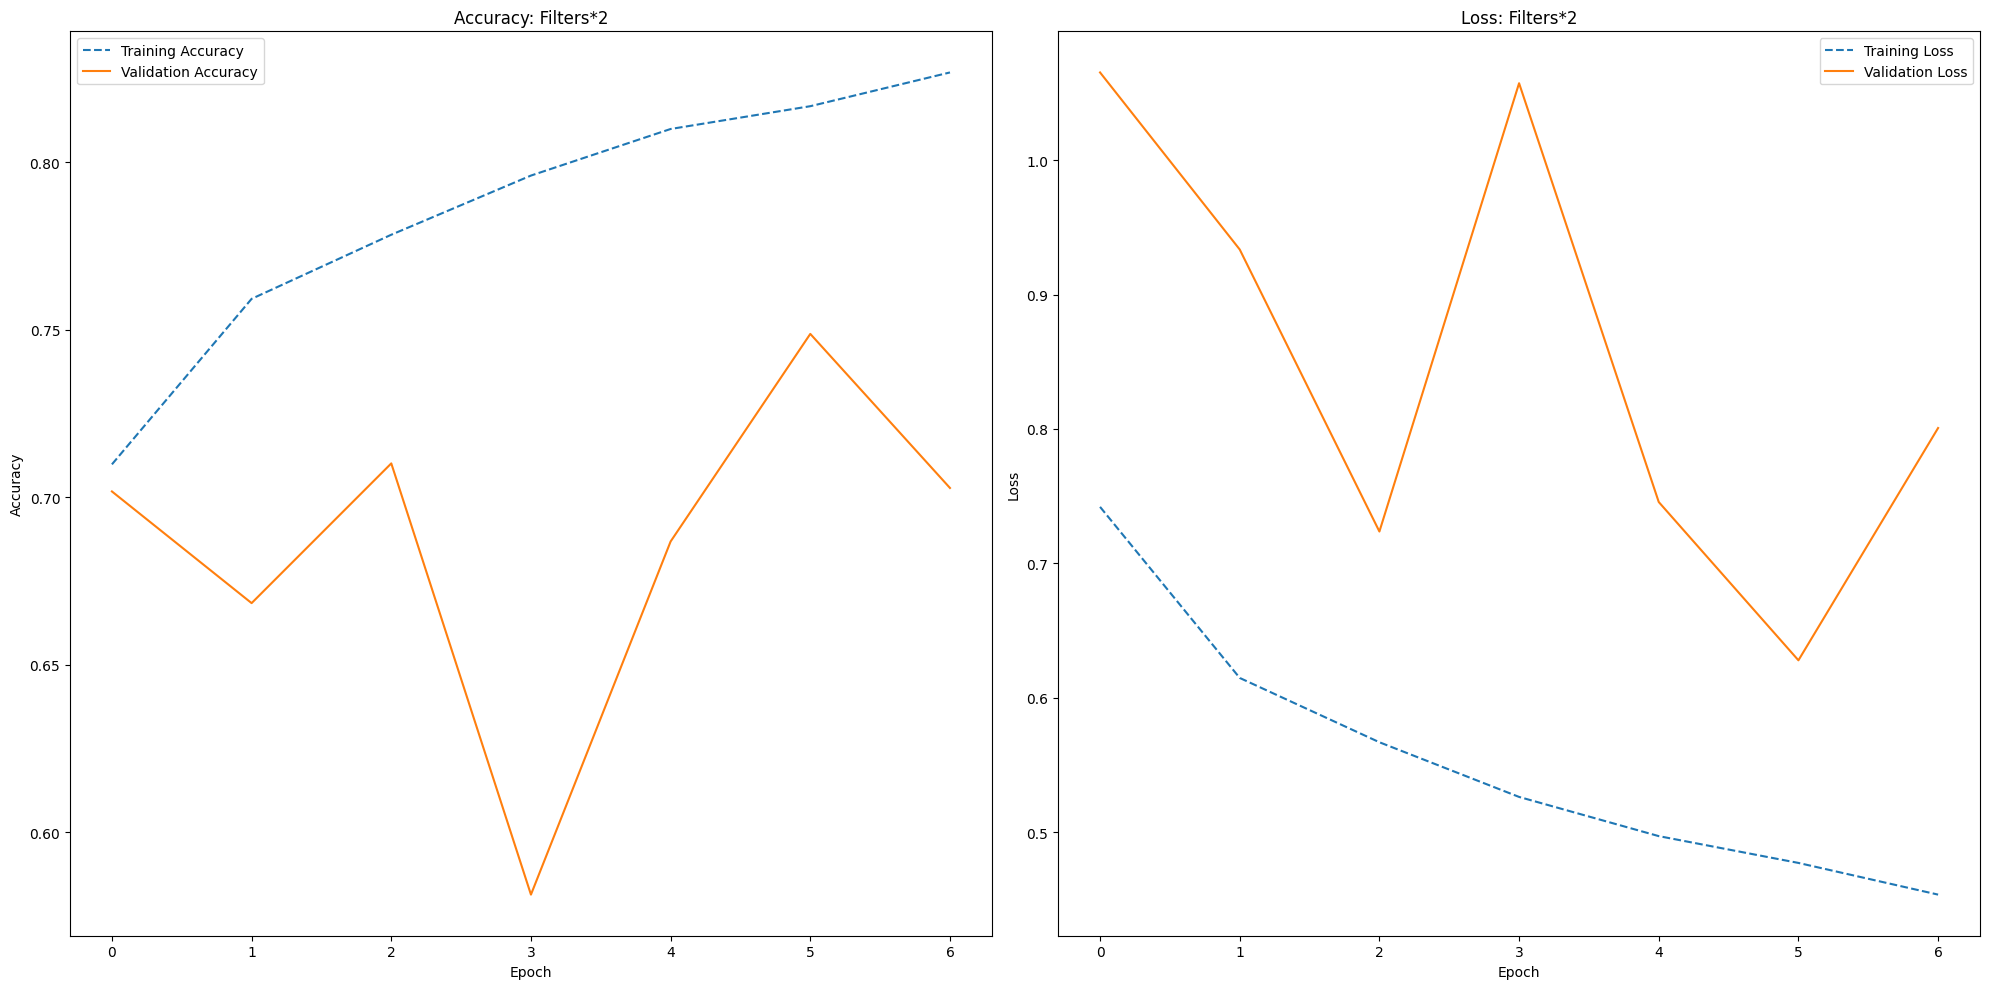

29938

In [11]:
params = {
    'name': 'Filters*2',
    'filters': [128, 256, 512, 1024, 1024],
    'kernel_size': (3,3),
    'activation': 'relu'
}

model = masked_unet(
    class_count=NUM_CLASSES,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    filters_list=params['filters'],
    kernel_size=params['kernel_size'],
    activation=params['activation']
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7, batch_size=8, verbose=1)

# Визуализация
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
plt.title(f'Accuracy: {params["name"]}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], '--', label='Training Loss')
plt.plot(history.history['val_loss'], '-', label='Validation Loss')
plt.title(f'Loss: {params["name"]}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Очистка
del model
gc.collect()

Модель с уменьшенными фильтрами (Filters_del_2)

Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 89s 228ms/step - loss: 1.1360 - sparse_categorical_accuracy: 0.6111 - val_loss: 0.9131 - val_sparse_categorical_accuracy: 0.7004
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - loss: 0.5836 - sparse_categorical_accuracy: 0.7735 - val_loss: 1.6673 - val_sparse_categorical_accuracy: 0.4598
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - loss: 0.5325 - sparse_categorical_accuracy: 0.7942 - val_loss: 0.7191 - val_sparse_categorical_accuracy: 0.7242
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - loss: 0.5017 - sparse_categorical_accuracy: 0.8075 - val_loss: 0.6738 - val_sparse_categorical_accuracy: 0.7348
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - loss: 0.4667 - sparse_categorical_accuracy: 0.8240 - val_loss: 0.6729 - val_sparse_categorical_accuracy: 0.7570
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - loss: 0.4556 - sparse_categorical_accuracy: 0.8280 - val_loss: 0.7003 - val_sparse_categorical_accuracy:

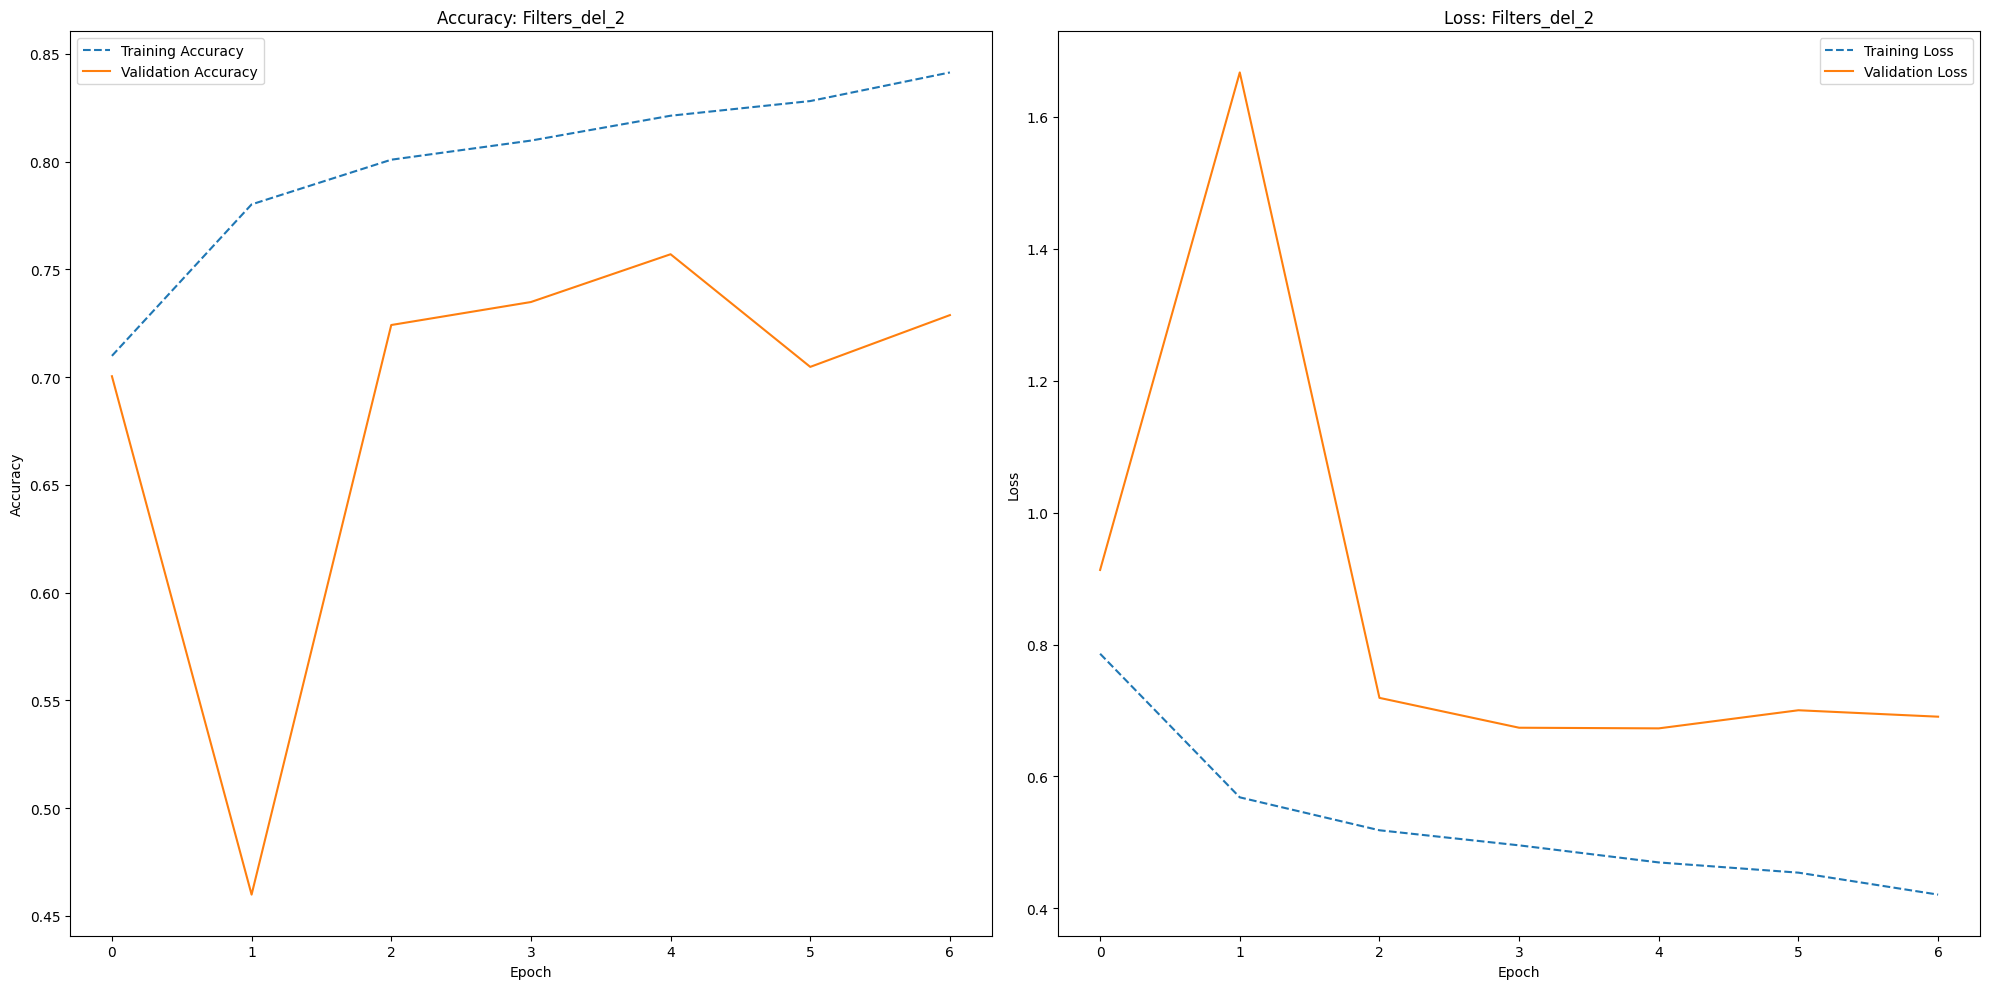

30036

In [12]:
params = {
    'name': 'Filters_del_2',
    'filters': [32, 64, 128, 256, 256],
    'kernel_size': (3,3),
    'activation': 'relu'
}

model = masked_unet(
    class_count=NUM_CLASSES,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    filters_list=params['filters'],
    kernel_size=params['kernel_size'],
    activation=params['activation']
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7, batch_size=8, verbose=1)

# Визуализация
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
plt.title(f'Accuracy: {params["name"]}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], '--', label='Training Loss')
plt.plot(history.history['val_loss'], '-', label='Validation Loss')
plt.title(f'Loss: {params["name"]}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Очистка
del model
gc.collect()

Модель с увеличенным ядром (Kernel 5,5)

Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 312s 968ms/step - loss: 0.9477 - sparse_categorical_accuracy: 0.6465 - val_loss: 5.9727 - val_sparse_categorical_accuracy: 0.3285
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 194s 721ms/step - loss: 0.6173 - sparse_categorical_accuracy: 0.7611 - val_loss: 1.0164 - val_sparse_categorical_accuracy: 0.5818
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 203s 727ms/step - loss: 0.5806 - sparse_categorical_accuracy: 0.7747 - val_loss: 0.7833 - val_sparse_categorical_accuracy: 0.7342
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 202s 727ms/step - loss: 0.5257 - sparse_categorical_accuracy: 0.7983 - val_loss: 0.6826 - val_sparse_categorical_accuracy: 0.7391
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 202s 727ms/step - loss: 0.5003 - sparse_categorical_accuracy: 0.8115 - val_loss: 0.7851 - val_sparse_categorical_accuracy: 0.6690
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 202s 727ms/step - loss: 0.4875 - sparse_categorical_accuracy: 0.8170 - val_loss: 0.6810 - val_sparse_categorical_acc

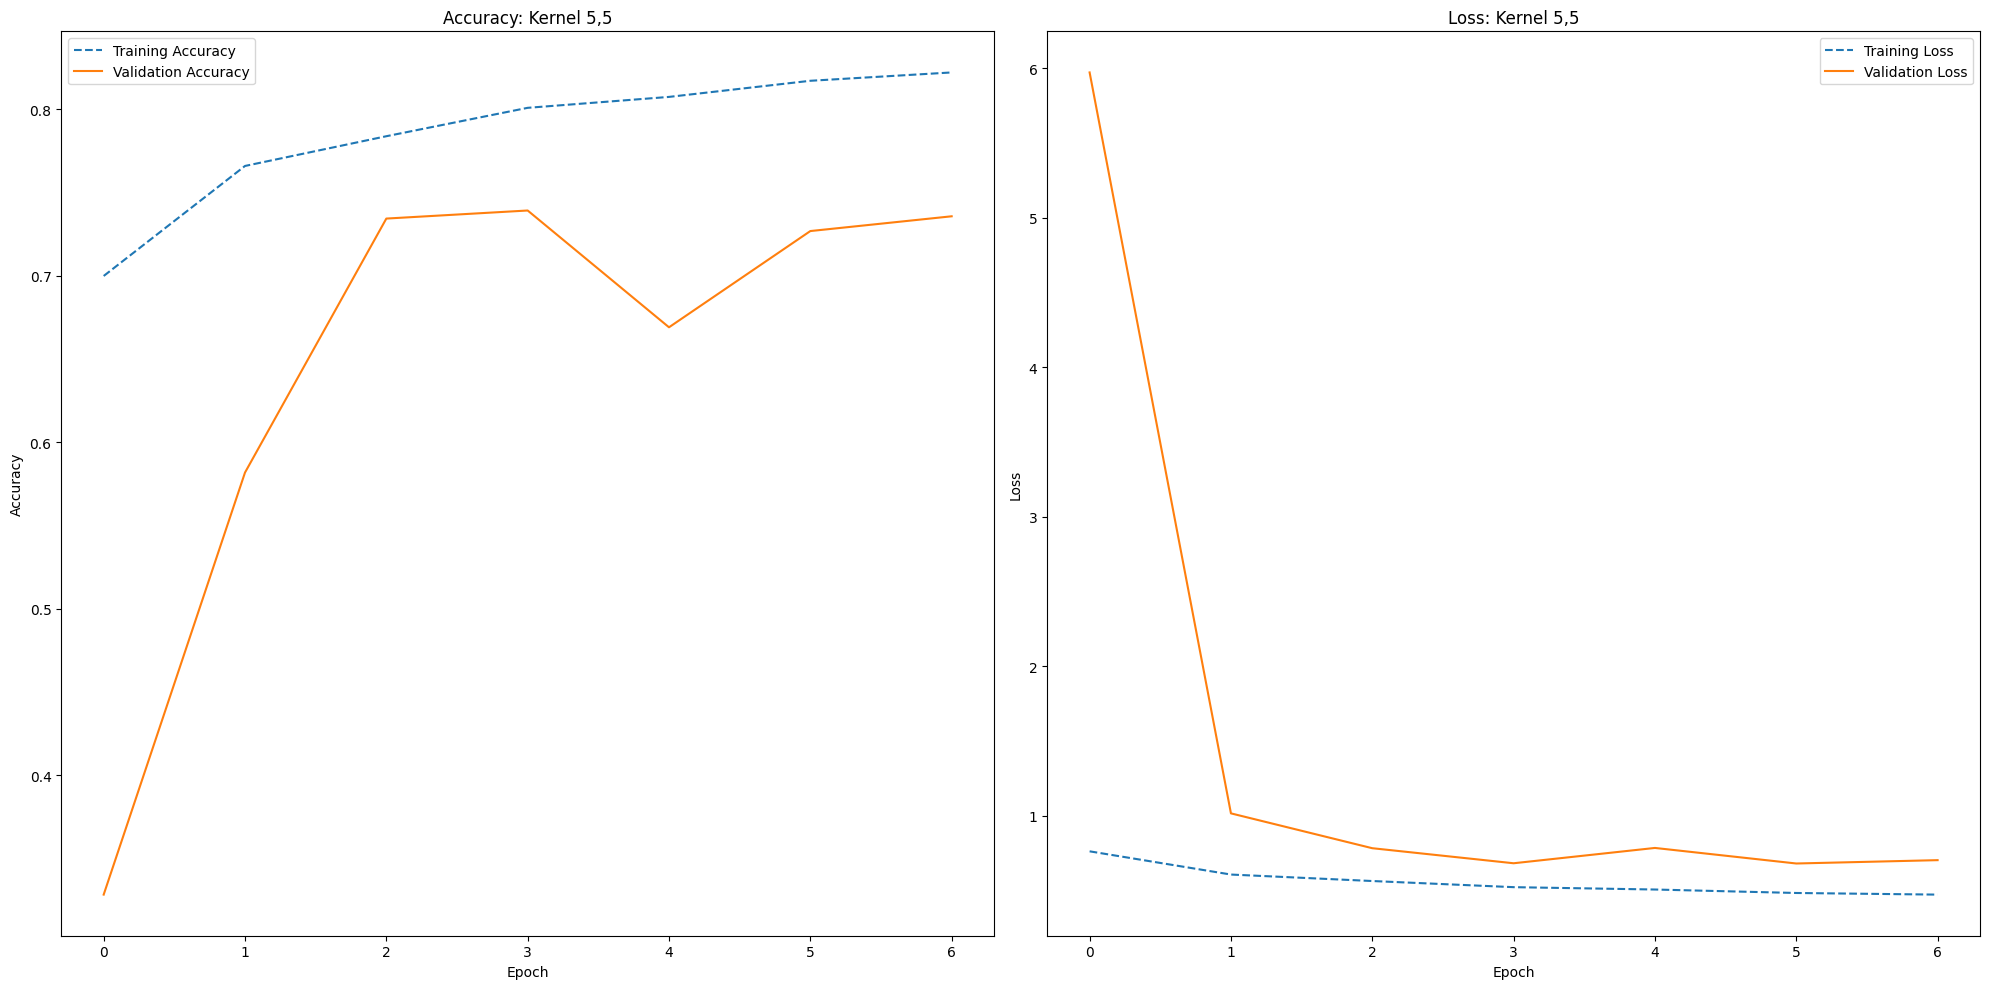

7525

In [8]:
params = {
    'name': 'Kernel 5,5',
    'filters': [64, 128, 256, 512, 512],
    'kernel_size': (5,5),
    'activation': 'relu'
}

model = masked_unet(
    class_count=NUM_CLASSES,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    filters_list=params['filters'],
    kernel_size=params['kernel_size'],
    activation=params['activation']
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7, batch_size=8, verbose=1)

# Визуализация
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
plt.title(f'Accuracy: {params["name"]}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], '--', label='Training Loss')
plt.plot(history.history['val_loss'], '-', label='Validation Loss')
plt.title(f'Loss: {params["name"]}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Очистка
del model
gc.collect()

Модель с активацией SELU

Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 183s 536ms/step - loss: 1.8816 - sparse_categorical_accuracy: 0.5418 - val_loss: 1.0926 - val_sparse_categorical_accuracy: 0.7065
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 123s 388ms/step - loss: 0.6912 - sparse_categorical_accuracy: 0.7232 - val_loss: 0.8177 - val_sparse_categorical_accuracy: 0.7055
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 389ms/step - loss: 0.6296 - sparse_categorical_accuracy: 0.7483 - val_loss: 0.8723 - val_sparse_categorical_accuracy: 0.6927
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 385ms/step - loss: 0.5847 - sparse_categorical_accuracy: 0.7696 - val_loss: 0.9854 - val_sparse_categorical_accuracy: 0.6243
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 385ms/step - loss: 0.5718 - sparse_categorical_accuracy: 0.7764 - val_loss: 0.6796 - val_sparse_categorical_accuracy: 0.7345
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 385ms/step - loss: 0.5279 - sparse_categorical_accuracy: 0.7961 - val_loss: 0.8566 - val_sparse_categorical_acc

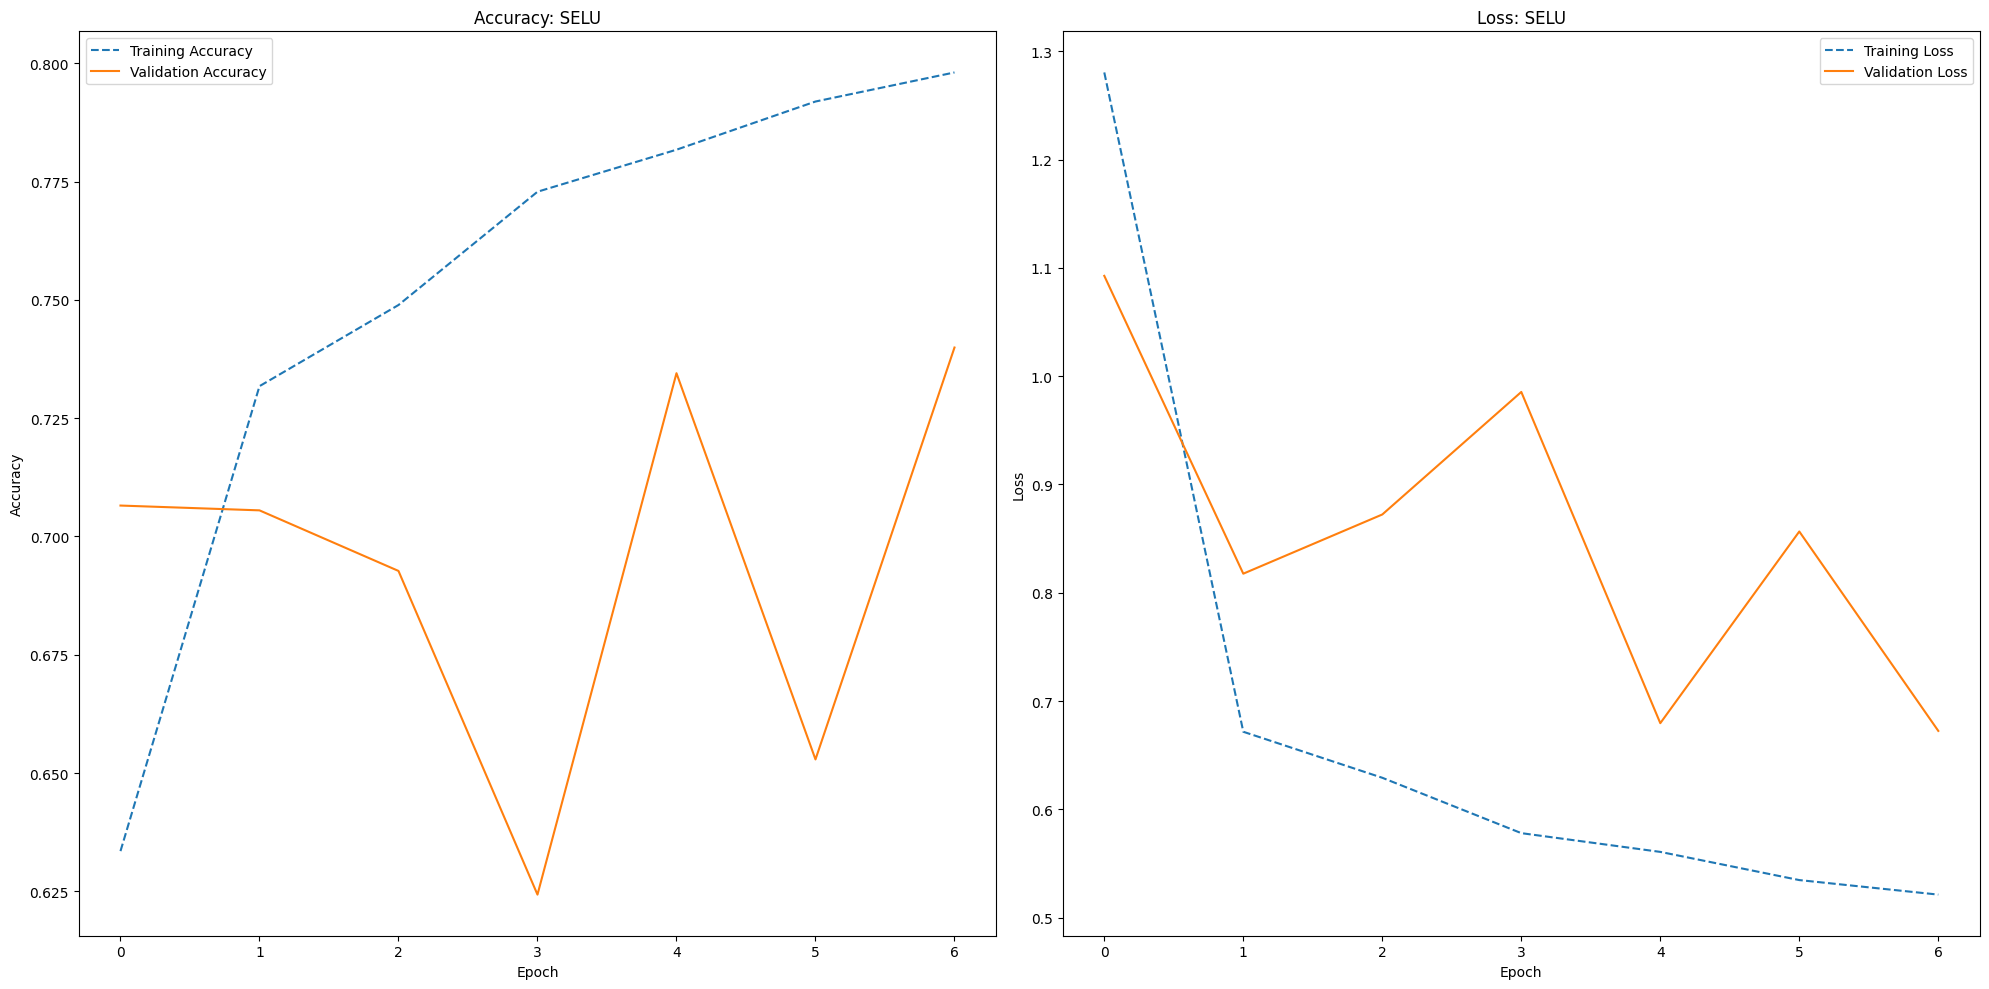

30159

In [9]:
params = {
    'name': 'SELU',
    'filters': [64, 128, 256, 512, 512],
    'kernel_size': (3,3),
    'activation': 'selu'
}

model = masked_unet(
    class_count=NUM_CLASSES,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    filters_list=params['filters'],
    kernel_size=params['kernel_size'],
    activation=params['activation']
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7, batch_size=8, verbose=1)

# Визуализация
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
plt.title(f'Accuracy: {params["name"]}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], '--', label='Training Loss')
plt.plot(history.history['val_loss'], '-', label='Validation Loss')
plt.title(f'Loss: {params["name"]}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Очистка
del model
gc.collect()

Модель с активацией ELU

Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 131s 448ms/step - loss: 1.1746 - sparse_categorical_accuracy: 0.6094 - val_loss: 1.4762 - val_sparse_categorical_accuracy: 0.6367
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 115s 388ms/step - loss: 0.6623 - sparse_categorical_accuracy: 0.7392 - val_loss: 0.8926 - val_sparse_categorical_accuracy: 0.7268
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 91s 384ms/step - loss: 0.6079 - sparse_categorical_accuracy: 0.7648 - val_loss: 1.5713 - val_sparse_categorical_accuracy: 0.4536
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 91s 384ms/step - loss: 0.5849 - sparse_categorical_accuracy: 0.7729 - val_loss: 0.8334 - val_sparse_categorical_accuracy: 0.6405
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 385ms/step - loss: 0.5474 - sparse_categorical_accuracy: 0.7866 - val_loss: 0.7248 - val_sparse_categorical_accuracy: 0.7077
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 385ms/step - loss: 0.5111 - sparse_categorical_accuracy: 0.8038 - val_loss: 0.6784 - val_sparse_categorical_accur

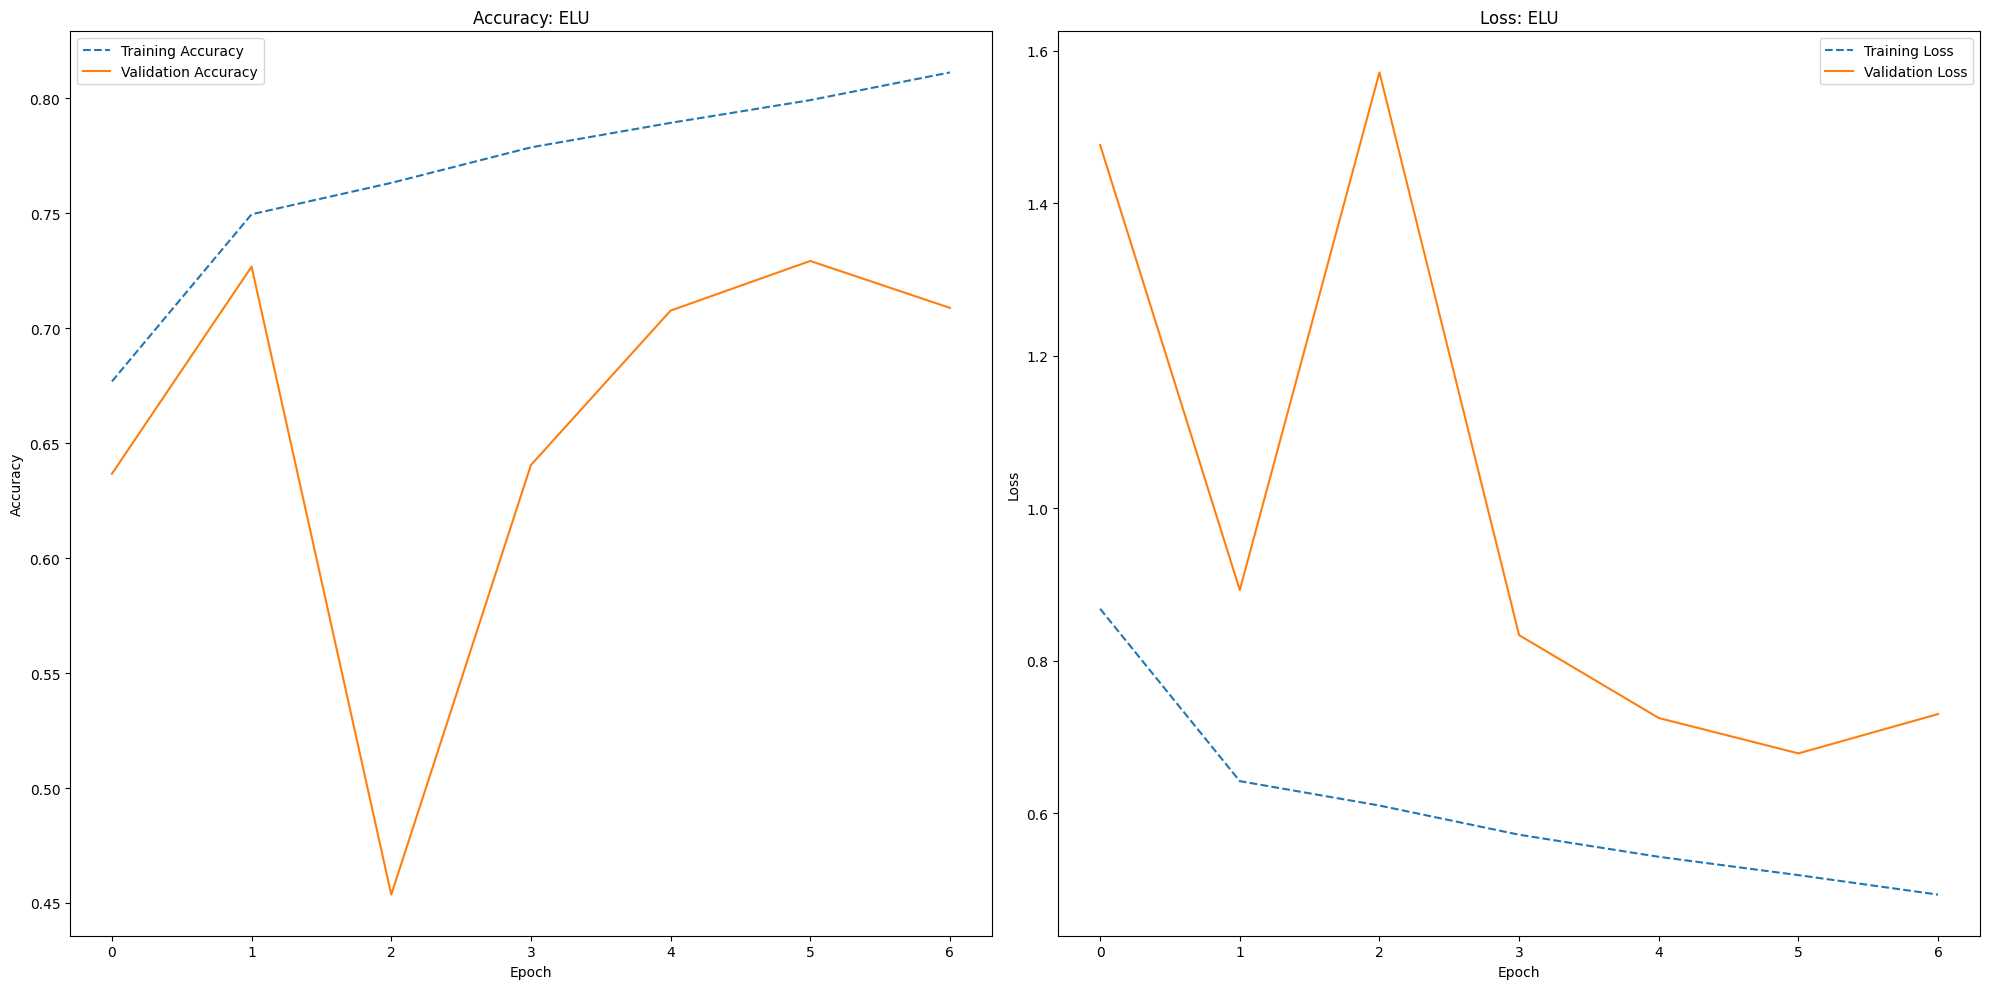

29774

In [10]:
params = {
    'name': 'ELU',
    'filters': [64, 128, 256, 512, 512],
    'kernel_size': (3,3),
    'activation': 'elu'
}

model = masked_unet(
    class_count=NUM_CLASSES,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    filters_list=params['filters'],
    kernel_size=params['kernel_size'],
    activation=params['activation']
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7, batch_size=8, verbose=1)

# Визуализация
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
plt.title(f'Accuracy: {params["name"]}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], '--', label='Training Loss')
plt.plot(history.history['val_loss'], '-', label='Validation Loss')
plt.title(f'Loss: {params["name"]}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Очистка
del model
gc.collect()

Модель с разными размерами ядер (Kernel_sizes)

Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 134s 458ms/step - loss: 1.0298 - sparse_categorical_accuracy: 0.6280 - val_loss: 1.1411 - val_sparse_categorical_accuracy: 0.4084
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 95s 401ms/step - loss: 0.7071 - sparse_categorical_accuracy: 0.7137 - val_loss: 0.8654 - val_sparse_categorical_accuracy: 0.6076
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 397ms/step - loss: 0.6668 - sparse_categorical_accuracy: 0.7275 - val_loss: 0.9842 - val_sparse_categorical_accuracy: 0.6014
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 143s 401ms/step - loss: 0.6379 - sparse_categorical_accuracy: 0.7391 - val_loss: 0.9975 - val_sparse_categorical_accuracy: 0.5910
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 397ms/step - loss: 0.5791 - sparse_categorical_accuracy: 0.7680 - val_loss: 0.8131 - val_sparse_categorical_accuracy: 0.6542
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 95s 397ms/step - loss: 0.5621 - sparse_categorical_accuracy: 0.7759 - val_loss: 0.8149 - val_sparse_categorical_accur

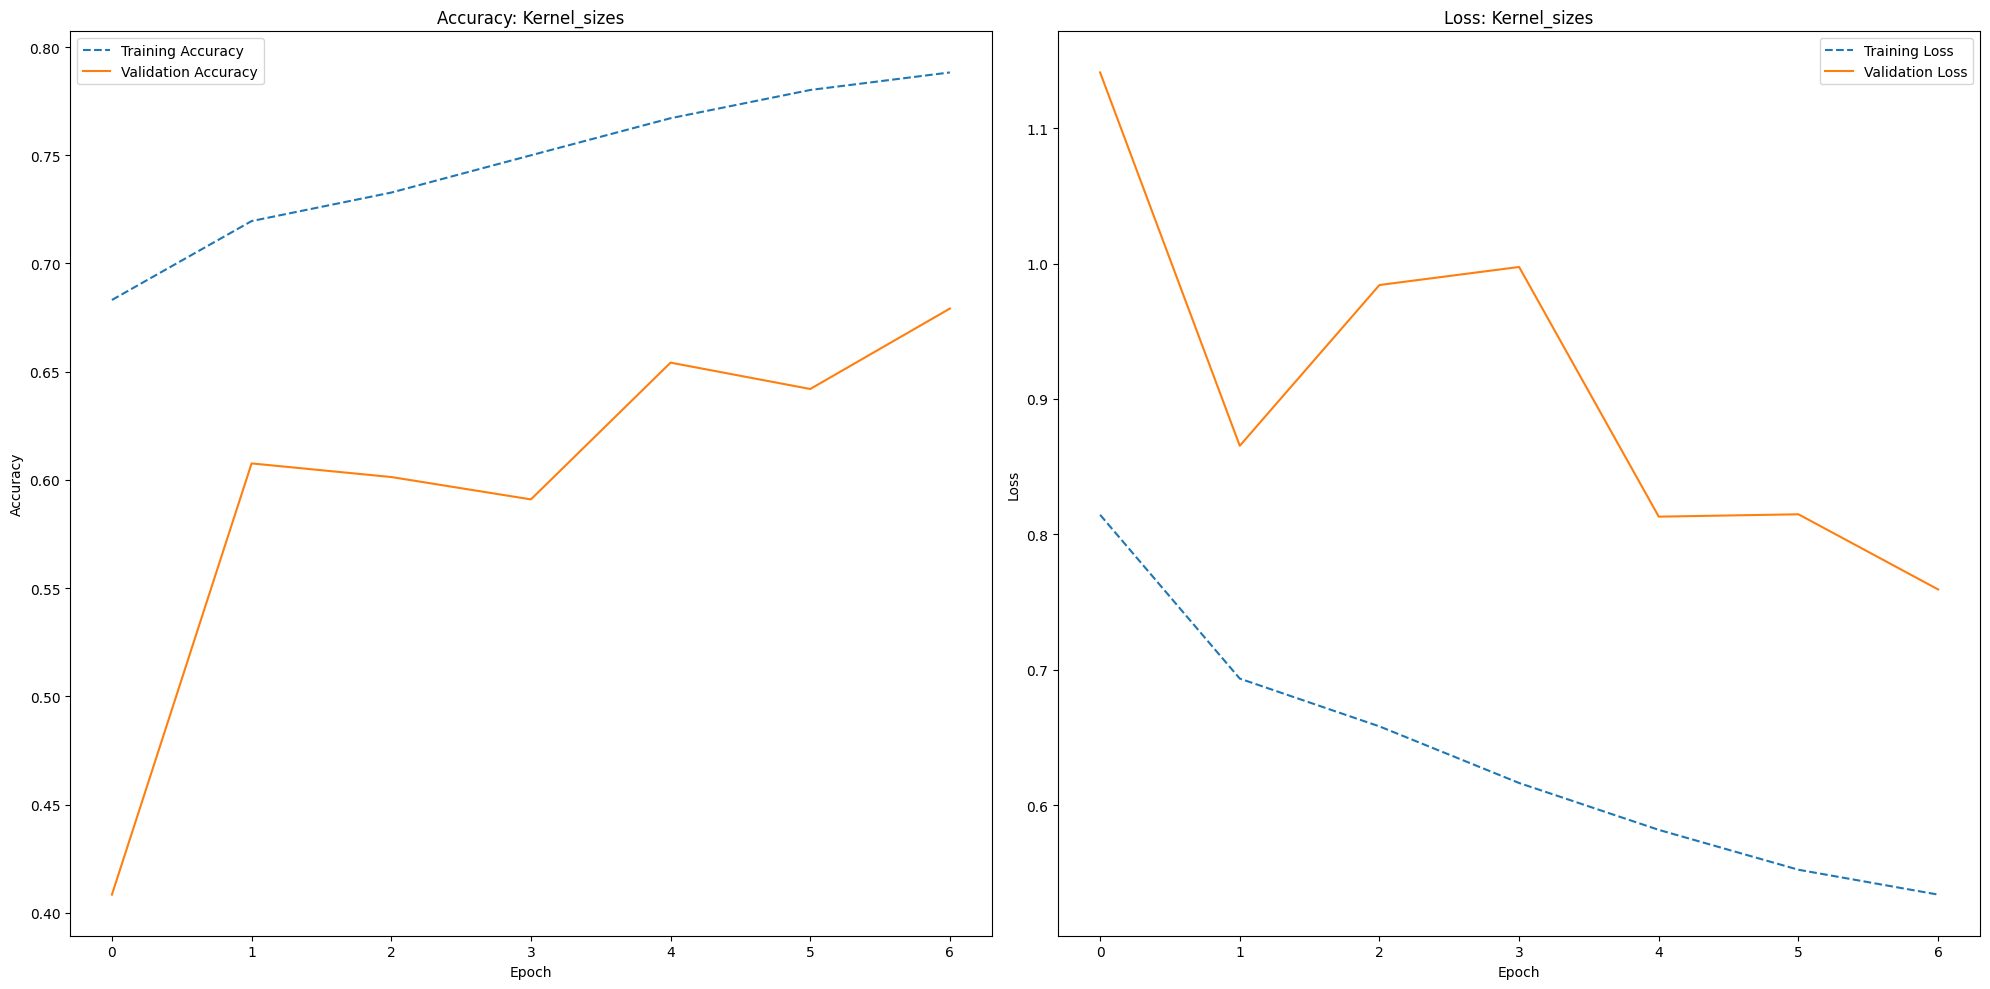

29954

In [11]:
params = {
    'name': 'Kernel_sizes',
    'filters': [64, 128, 256, 512, 512],
    'kernel_size': [(5,5), (3,3), (3,3), (1,1), (1,1)],
    'activation': 'relu'
}

model = masked_unet(
    class_count=NUM_CLASSES,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    filters_list=params['filters'],
    kernel_size=params['kernel_size'],
    activation=params['activation']
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7, batch_size=8, verbose=1)

# Визуализация
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
plt.title(f'Accuracy: {params["name"]}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], '--', label='Training Loss')
plt.plot(history.history['val_loss'], '-', label='Validation Loss')
plt.title(f'Loss: {params["name"]}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Очистка
del model
gc.collect()

Модель с ядром 5x5 и ELU (Kernel 5,5 и ELU)

Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 215s 804ms/step - loss: 1.2448 - sparse_categorical_accuracy: 0.6264 - val_loss: 1.1232 - val_sparse_categorical_accuracy: 0.6935
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 173s 729ms/step - loss: 0.6374 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.8163 - val_sparse_categorical_accuracy: 0.7135
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 203s 734ms/step - loss: 0.5807 - sparse_categorical_accuracy: 0.7756 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.7363
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 201s 729ms/step - loss: 0.5621 - sparse_categorical_accuracy: 0.7843 - val_loss: 0.6889 - val_sparse_categorical_accuracy: 0.7207
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 202s 728ms/step - loss: 0.5653 - sparse_categorical_accuracy: 0.7797 - val_loss: 1.2069 - val_sparse_categorical_accuracy: 0.5333
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 203s 734ms/step - loss: 0.5379 - sparse_categorical_accuracy: 0.7938 - val_loss: 0.7626 - val_sparse_categorical_acc

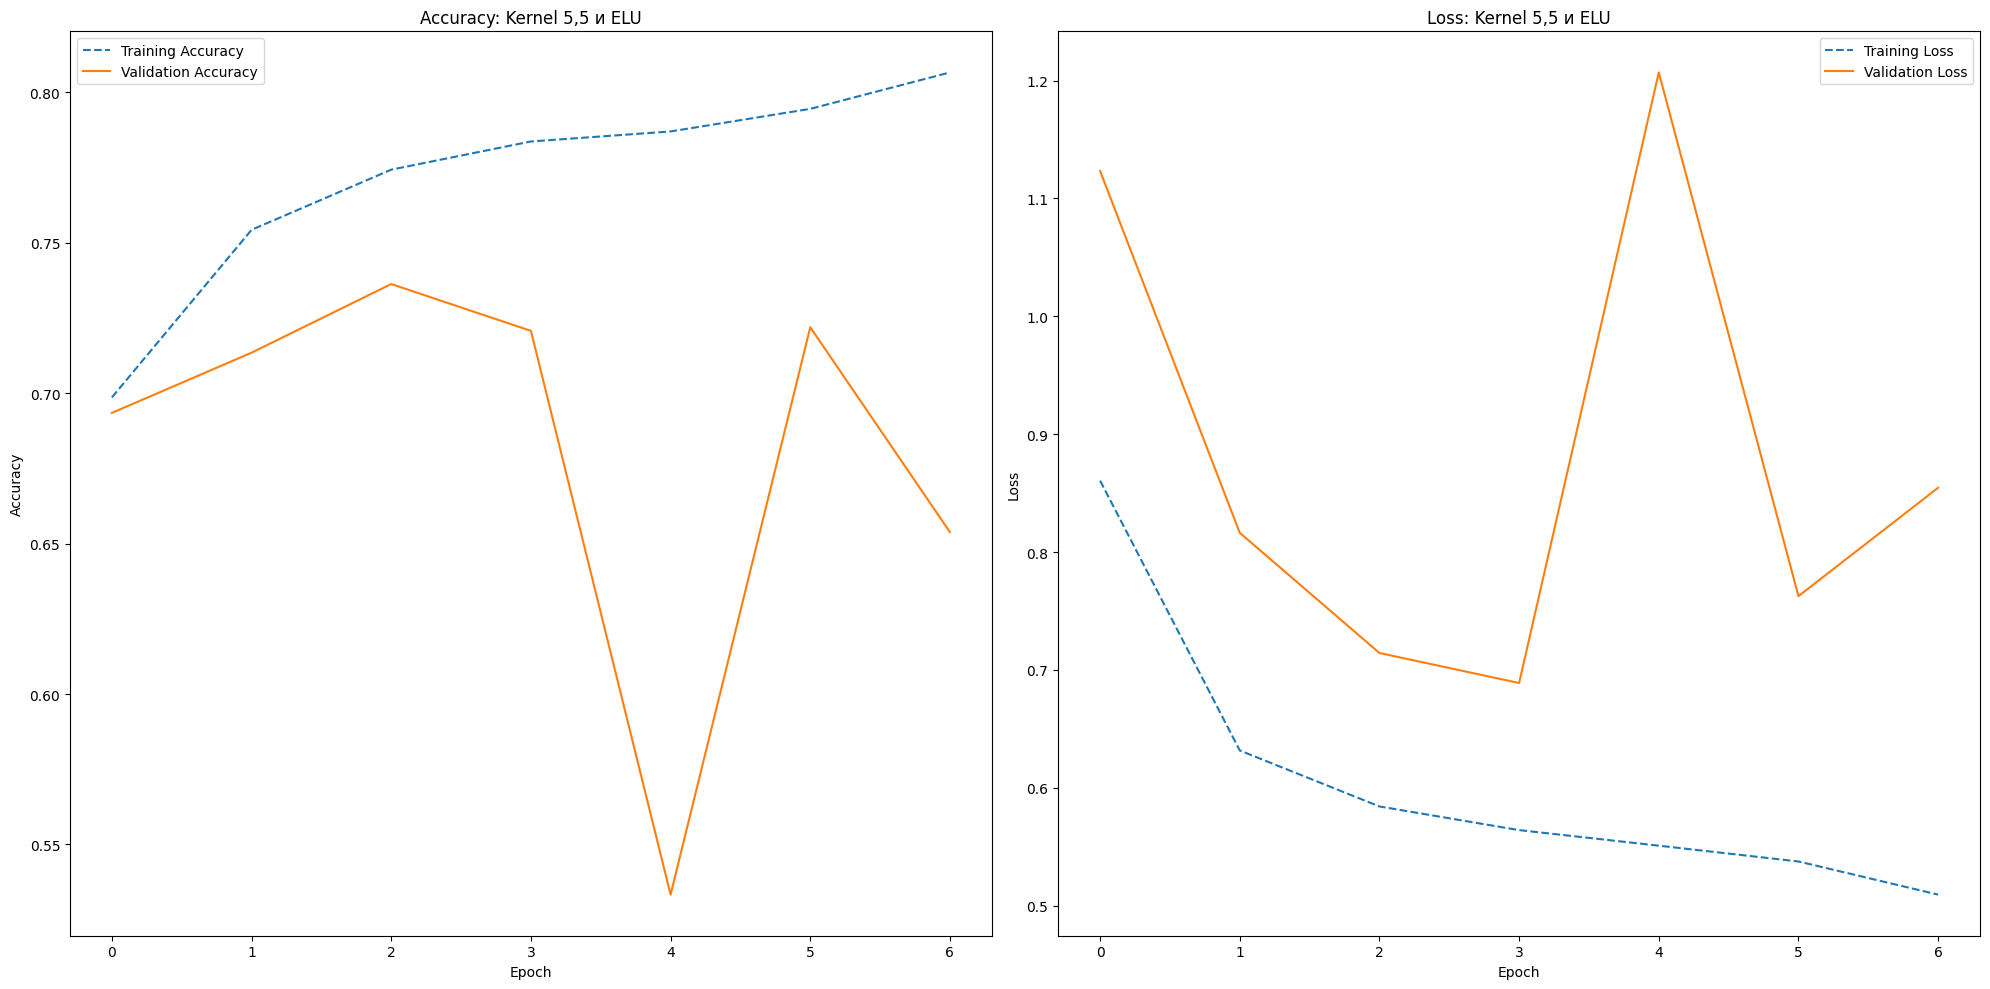

29804

In [12]:
params = {
    'name': 'Kernel 5,5 и ELU',
    'filters': [64, 128, 256, 512, 512],
    'kernel_size': (5,5),
    'activation': 'elu'
}

model = masked_unet(
    class_count=NUM_CLASSES,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    filters_list=params['filters'],
    kernel_size=params['kernel_size'],
    activation=params['activation']
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7, batch_size=8, verbose=1)

# Визуализация
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
plt.title(f'Accuracy: {params["name"]}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], '--', label='Training Loss')
plt.plot(history.history['val_loss'], '-', label='Validation Loss')
plt.title(f'Loss: {params["name"]}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Очистка
del model
gc.collect()

Модель с удвоенными фильтрами и SELU (Filters*2 и SELU)

In [ ]:
params = {
    'name': 'Filters*2 и SELU',
    'filters': [128, 256, 512, 1024, 1024],
    'kernel_size': (3,3),
    'activation': 'selu'
}

model = masked_unet(
    class_count=NUM_CLASSES,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    filters_list=params['filters'],
    kernel_size=params['kernel_size'],
    activation=params['activation']
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7, batch_size=8, verbose=1)

# Визуализация
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
plt.title(f'Accuracy: {params["name"]}')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], '--', label='Training Loss')
plt.plot(history.history['val_loss'], '-', label='Validation Loss')
plt.title(f'Loss: {params["name"]}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Очистка
del model
gc.collect()

Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 476s 2s/step - loss: 1.8702 - sparse_categorical_accuracy: 0.5156 - val_loss: 1.4761 - val_sparse_categorical_accuracy: 0.6140
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - loss: 0.7083 - sparse_categorical_accuracy: 0.7162 - val_loss: 0.8452 - val_sparse_categorical_accuracy: 0.6919
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - loss: 0.6511 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.8452 - val_sparse_categorical_accuracy: 0.7092
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - loss: 0.6092 - sparse_categorical_accuracy: 0.7624 - val_loss: 0.9257 - val_sparse_categorical_accuracy: 0.6239
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.5515 - sparse_categorical_accuracy: 0.7861 - val_loss: 0.6972 - val_sparse_categorical_accuracy: 0.7147
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.5494 - sparse_categorical_accuracy: 0.7850 - val_loss: 0.9292 - val_sparse_categorical_accuracy: 0.6343
Epoc